In [ ]:
!pip install ray[data]

In [ ]:
import ray
ray.init()

2025-08-23 03:27:04,130	INFO worker.py:1927 -- Started a local Ray instance.


Python version:,3.12.11
Ray version:,2.48.0


In [ ]:
from huggingface_hub import hf_hub_url

repo  = "Francesco/insects-mytwu"
files = [
    hf_hub_url(repo, "data/test-00000-of-00001-670031141e816b9b.parquet", repo_type="dataset"),
    hf_hub_url(repo, "data/test-00000-of-00001-670031141e816b9b.parquet", repo_type="dataset"),
    hf_hub_url(repo, "data/validation-00000-of-00001-876de533d76d48c6.parquet", repo_type="dataset")
]

ds = ray.data.read_parquet(files, columns=["image_id", "image"])

Parquet Files Sample 0:   0%|          | 0.00/2.00 [00:00<?, ? file/s]

In [ ]:
print(ds)

Dataset(
   num_rows=498,
   schema={image_id: int64, image: struct<bytes: binary, path: string>}
)


In [ ]:
import pyarrow as pa

def first_row_arrow(tbl: pa.Table) -> pa.Table:
    # keep exactly one representative row per group
    return tbl.slice(0, 1)

ds = (
    ds
    .sort("image_id")  # optional: makes which row is “first” deterministic
    .groupby("image_id")
    .map_groups(first_row_arrow, batch_format="pyarrow")
)


In [ ]:
import io
import numpy as np
from PIL import Image

def decode_to_rgb_row(row):
    b = row["image"]["bytes"]  # nested in the struct
    row["image"] = np.asarray(Image.open(io.BytesIO(b)).convert("RGB"), dtype=np.uint8)
    return row

ds = ds.map(decode_to_rgb_row)   # <-- row-wise map
ds = ds.materialize()

2025-08-23 03:27:31,112	INFO logging.py:295 -- Registered dataset logger for dataset dataset_5_0
2025-08-23 03:27:31,136	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_5_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:27:31,136	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_5_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[Sort] -> AllToAllOperator[Sort] -> TaskPoolMapOperator[MapBatches(first_row_arrow)->Map(decode_to_rgb_row)]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(8) 1: 0.00 row [00:00, ? row/s]

- Sort 2: 0.00 row [00:00, ? row/s]

Sort Sample 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 5:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 6: 0.00 row [00:00, ? row/s]

Sort Sample 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(first_row_arrow)->Map(decode_to_rgb_row) 10: 0.00 row [00:00, ? row/s]

2025-08-23 03:27:31,263	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 42.9% of available memory (16.9GB out of 39.5GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-08-23 03:27:36,421	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_5_0 execution finished in 5.28 seconds


In [ ]:
print(ds)

MaterializedDataset(
   num_blocks=24,
   num_rows=199,
   schema={
      image_id: int64,
      image: numpy.ndarray(shape=(640, 640, 3), dtype=uint8)
   }
)


2025-08-23 03:27:45,391	INFO dataset.py:3055 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-08-23 03:27:45,393	INFO logging.py:295 -- Registered dataset logger for dataset dataset_7_0
2025-08-23 03:27:45,395	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:27:45,396	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=2]


Running 0: 0.00 row [00:00, ? row/s]

- limit=2 1: 0.00 row [00:00, ? row/s]

2025-08-23 03:27:45,452	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_7_0 execution finished in 0.05 seconds


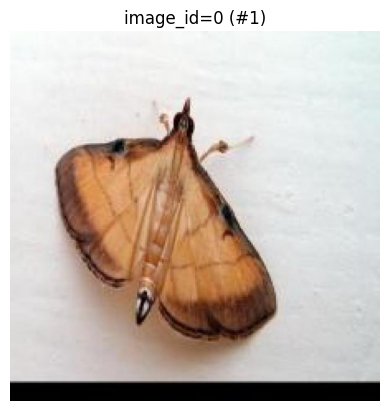

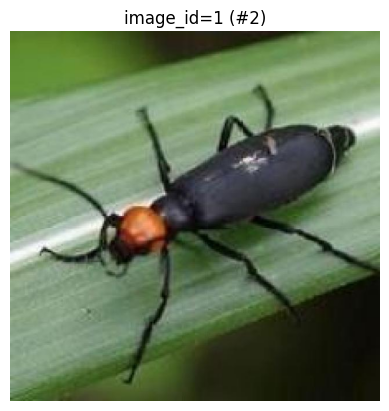

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

rows = ds.take(2)  # returns a list of dicts

for i, row in enumerate(rows, 1):
    img = row["image"]            # HxWx3 uint8
    img_id = row["image_id"]
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"image_id={img_id} (#{i})")


In [ ]:
import numpy as np
from PIL import Image
import torch
from transformers import CLIPModel, CLIPProcessor

In [ ]:
class EmbeddingGenerator(object):
    def __init__(self, model_id):
        # Load CLIP model and processor.
        self.model = CLIPModel.from_pretrained(model_id)
        self.processor = CLIPProcessor.from_pretrained(model_id)

    def __call__(self, batch, device="cpu"):
        # Load and preprocess images.
        images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in batch["image"]]
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(device)

        # Generate embeddings.
        self.model.to(device)
        with torch.inference_mode():
            batch["embedding"] = self.model.get_image_features(**inputs).cpu().numpy()

        return batch

In [ ]:
# Batch embeddings.
embeddings_ds = ds.map_batches(
    EmbeddingGenerator,
    fn_constructor_kwargs={"model_id": "openai/clip-vit-base-patch32"},  # class kwargs
    fn_kwargs={"device": "cuda"},  # __call__ kwargs
    concurrency=1,
    batch_size=128,
    num_gpus=1,
    accelerator_type="L4",
)

In [ ]:
embeddings_ds = embeddings_ds.materialize()

2025-08-23 03:28:05,636	INFO logging.py:295 -- Registered dataset logger for dataset dataset_9_0
2025-08-23 03:28:05,639	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_9_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:28:05,639	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_9_0: InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbeddingGenerator)]


Running 0: 0.00 row [00:00, ? row/s]

- MapBatches(EmbeddingGenerator) 1: 0.00 row [00:00, ? row/s]

(_MapWorker pid=11603) 2025-08-23 03:28:12.129901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(_MapWorker pid=11603) 2025-08-23 03:28:12.147076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_MapWorker pid=11603) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_MapWorker pid=11603) E0000 00:00:1755919692.168828   11603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_MapWorker pid=11603) E0000 00:00:1755919692.175263   11603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register fact

In [ ]:
print(embeddings_ds)

MaterializedDataset(
   num_blocks=3,
   num_rows=199,
   schema={
      image_id: int64,
      image: numpy.ndarray(shape=(640, 640, 3), dtype=uint8),
      embedding: numpy.ndarray(shape=(512,), dtype=float)
   }
)


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 80.4 MB/s eta 0:00:00


In [ ]:
# Collect embeddings (float32, L2-normalized) and ids
rows = embeddings_ds.select_columns(["image_id","embedding"]).take_all()
ids  = np.array([r["image_id"] for r in rows])
X    = np.stack([r["embedding"] for r in rows]).astype("float32")  # [N,D]

# FAISS cosine ≈ inner-product if X is normalized
import faiss
d = X.shape[1]
index = faiss.IndexFlatIP(d)
index.add(X)

# Query top-5 neighbors for the first 3 images
D, I = index.search(X[:3], 5)  # D: similarity scores, I: indices
print(ids[I], D)


2025-08-23 03:28:54,711	INFO logging.py:295 -- Registered dataset logger for dataset dataset_11_0
2025-08-23 03:28:54,714	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_11_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:28:54,714	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_11_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project]


Running 0: 0.00 row [00:00, ? row/s]

- Project 1: 0.00 row [00:00, ? row/s]

2025-08-23 03:28:54,775	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_11_0 execution finished in 0.06 seconds


[[  0  43 196 137 195]
 [  1 134  48  37  80]
 [  2 196 160 100  23]] [[101.4644    90.3332    89.980865  88.25511   86.18678 ]
 [ 94.67752   90.0469    88.75019   87.50917   87.452576]
 [ 99.4963    93.78775   86.40631   86.06505   85.48547 ]]


2025-08-23 03:35:33,366	INFO logging.py:295 -- Registered dataset logger for dataset dataset_20_0
2025-08-23 03:35:33,369	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_20_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:35:33,370	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_20_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project]


Running 0: 0.00 row [00:00, ? row/s]

- Project 1: 0.00 row [00:00, ? row/s]

2025-08-23 03:35:33,449	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_20_0 execution finished in 0.08 seconds


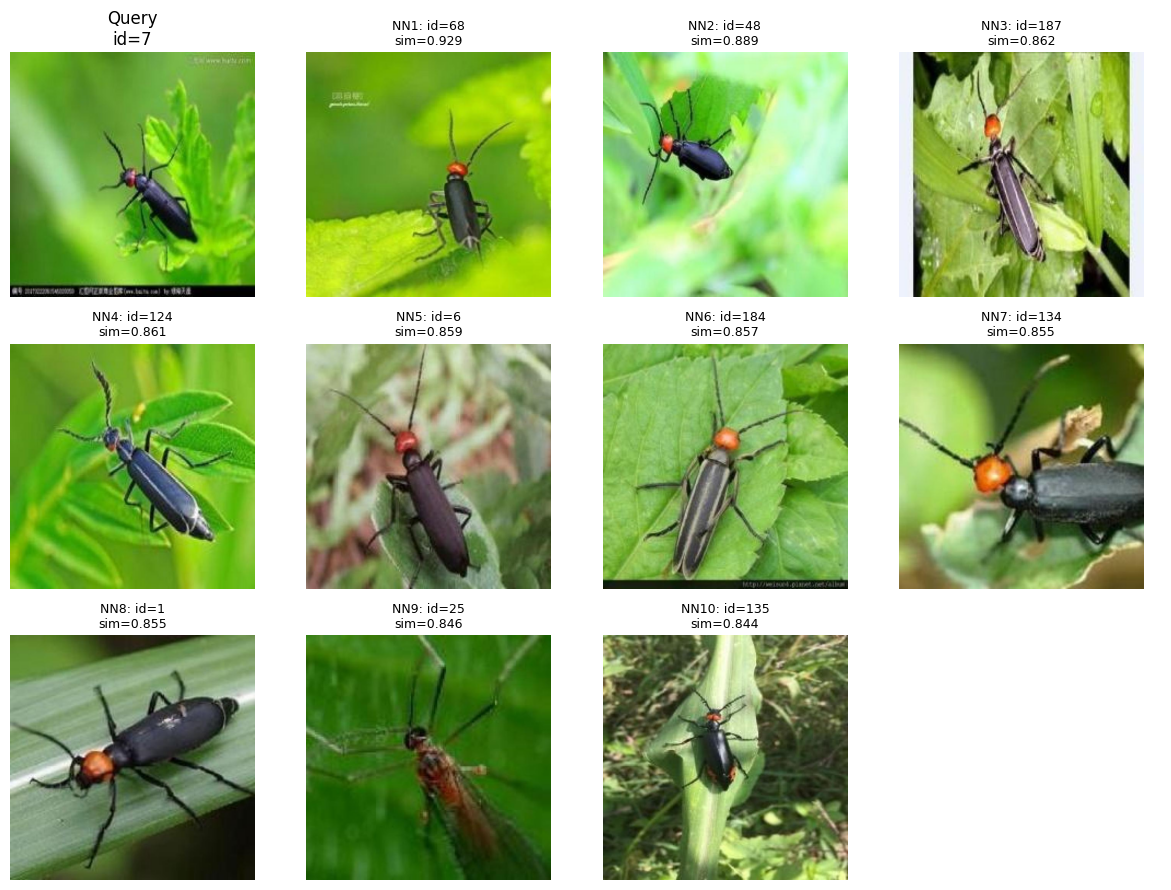

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If your dataset is named `embeddings_ds`, uncomment the next line:
# ds = embeddings_ds

# Pull everything we need into memory (N=498 is tiny)
rows = embeddings_ds.select_columns(["image_id", "image", "embedding"]).take_all()

ids   = np.array([r["image_id"] for r in rows])
imgs  = [r["image"] for r in rows]                          # list of HxWx3 uint8
X     = np.stack([r["embedding"] for r in rows]).astype("float32")  # [N, D]

# Normalize embeddings (safe even if already normalized)
X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-12

q_num =7
# ---- Query = first row ----
q_img  = imgs[q_num]
q_id   = int(ids[q_num])
q      = X[q_num]                                               # [D]
sims   = X @ q                                              # cosine similarity to all images
order  = np.argsort(-sims)                                  # descending
neighbors_idx = [i for i in order if i != q_num][:10]           # exclude self

# ---- Plot: 3x4 grid: query + 10 neighbors ----
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

# Slot 0 = query
axes[0].imshow(q_img)
axes[0].set_title(f"Query\nid={q_id}")
axes[0].axis("off")

# Slots 1..10 = neighbors
for k, idx in enumerate(neighbors_idx, start=1):
    axes[k].imshow(imgs[idx])
    axes[k].set_title(f"NN{k}: id={int(ids[idx])}\nsim={sims[idx]:.3f}", fontsize=9)
    axes[k].axis("off")

# Any leftover axes (e.g., slot 11) -> hide
for j in range(1 + len(neighbors_idx), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
path = os.path.join("/content/", "output")
embeddings_ds.write_parquet(path)

2025-08-23 03:57:23,758	INFO logging.py:295 -- Registered dataset logger for dataset dataset_56_0
2025-08-23 03:57:23,759	INFO logging.py:303 -- dataset_56_0 registers for logging while another dataset dataset_28_0 is also logging. For performance reasons, we will not log to the dataset dataset_56_0 until it is the only active dataset.
2025-08-23 03:57:23,762	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_56_0. Full logs are in /tmp/ray/session_2025-08-23_03-27-02_616909_9382/logs/ray-data
2025-08-23 03:57:23,762	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_56_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Write]


Running 0: 0.00 row [00:00, ? row/s]

- Write 1: 0.00 row [00:00, ? row/s]

(Write pid=9809) FilenameProvider have to provide proper filename template including '{{i}}' macro to ensure unique filenames when writing multiple files. Appending '{{i}}' macro to the end of the file. For more details on the expected filename template checkout PyArrow's `write_to_dataset` API


(autoscaler +30m22s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'num_gpus': 1.0}. Add suitable node types to this cluster to resolve this issue.


2025-08-23 03:57:28,531	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_56_0 execution finished in 4.77 seconds
2025-08-23 03:57:28,556	INFO dataset.py:4619 -- Data sink Parquet finished. 199 rows and 233.6MB data written.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!zip -r /content/drive/MyDrive/clip_output/output.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/9_ace5c466403243348e41b3df6f654347_000002_000000-0.parquet